# 网络训练采用微调的方法



In [2]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

读取数据集

In [3]:
data_dir = r'.\data\dog' #目标数据集路径
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train')) #在目标数据集下细分训练集和验证集
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'))

# 显示图像样例
图像的大小和纵横比各有不同

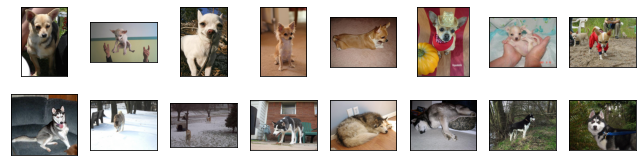

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

# 数据增强

In [5]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

# 定义和初始化模型
可以用多种模型。具体看models库下的网络结构

In [6]:
classes=10   #10表示目标数据集的类别，我们代码样例数据集采用的10类狗狗，所以这里设置为10
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, classes)
nn.init.xavier_uniform_(finetune_net.fc.weight); #采用迁移学习中只训练全连接层的方法

微调模型

In [7]:
#num_epochs表示跑的轮数周期，10~20次左右较好！
def train_fine_tuning(net, learning_rate, batch_size=64, num_epochs=3,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'val'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]

        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)
    torch.save(net.state_dict(), 'resnet18-1.params')#保存训练的模型，生成的文件名resnet18-1.params有40多兆

使用较小的学习率

loss 0.654, train acc 0.791, test acc 0.886
14.1 examples/sec on [device(type='cpu')]


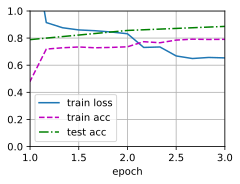

In [8]:
train_fine_tuning(finetune_net, 5e-5)

loss 0.506, train acc 0.841, test acc 0.894
14.2 examples/sec on [device(type='cpu')]


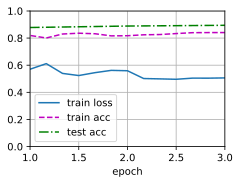

In [9]:
train_fine_tuning(finetune_net, 2e-5)

如果是gpu跑的跑完执行下面一行进行资源释放

In [11]:
torch.cuda.empty_cache()